In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Overview of Preprocessing



Original Annotaion Format of VisDrone Dataset

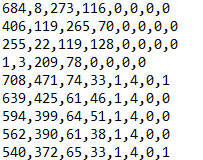

We convert this to PASCAL format, which is a standard format for bounding boxes<br>
<br>
This conversion is done locally as it is not supported on Google Colab

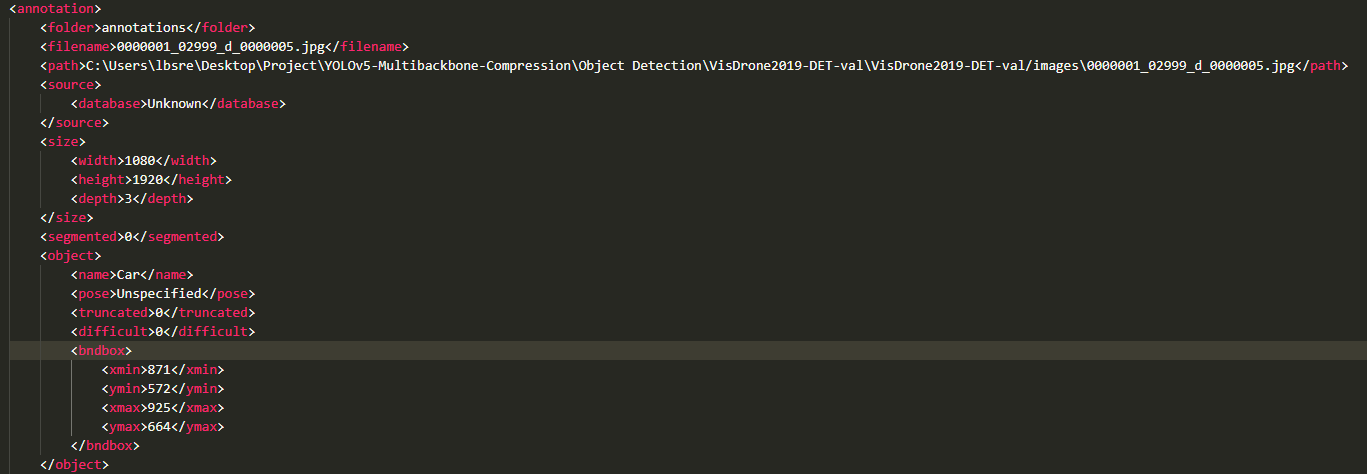

## YOLO

We then convert PASCAL format to YOLO format

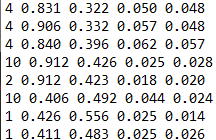

## RetinaNet

PASCAL format is then converted to a annotations.CSV file which contains:
1. File Path
2. Image Width
3. Image Height
4. Class Label
5. Xmin
6. Ymin
7. Xmax
8. Ymax


Selective columns from the annotations csv are used for RetinaNet.

## SSD MobileNet
SSD MobileNet needs TensorFlow records format<br>
This conversion is done locally as it is not supported on google colab

# Preprocessing for YOLO

## Cloning YOLOv5 Repo

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 13961, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 13961 (delta 158), reused 204 (delta 138), pack-reused 13715
Receiving objects: 100% (13961/13961), 13.29 MiB | 27.59 MiB/s, done.
Resolving deltas: 100% (9611/9611), done.


## Installing all the requried lib's

In [ ]:
!pip install -r yolov5/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'yolov5/requirements.txt'


Original annotaions:-

 bbox_left>	     The x coordinate of the top-left corner of the predicted bounding box

 bbox_top>	     The y coordinate of the top-left corner of the predicted object bounding box

 bbox_width>	     The width in pixels of the predicted object bounding box

bbox_height>	     The height in pixels of the predicted object bounding box

   score>	     The score in the DETECTION file indicates the confidence of the predicted bounding box enclosing
                     an object instance.
                     The score in GROUNDTRUTH file is set to 1 or 0. 1 indicates the bounding box is considered in evaluation,
                     while 0 indicates the bounding box will be ignored.
                      
object_category>    The object category indicates the type of annotated object, (i.e., ignored regions(0), pedestrian(1),
                     people(2), bicycle(3), car(4), van(5), truck(6), tricycle(7), awning-tricycle(8), bus(9), motor(10),
                     others(11))
                      
truncation>	     The score in the DETECTION result file should be set to the constant -1.
                     The score in the GROUNDTRUTH file indicates the degree of object parts appears outside a frame
                     (i.e., no truncation = 0 (truncation ratio 0%), and partial truncation = 1 (truncation ratio 1% ~ 50%)).
                      
occlusion>	     The score in the DETECTION file should be set to the constant -1.
                     The score in the GROUNDTRUTH file indicates the fraction of objects being occluded (i.e., no occlusion = 0
                     (occlusion ratio 0%), partial occlusion = 1 (occlusion ratio 1% ~ 50%), and heavy occlusion = 2
                     (occlusion ratio 50% ~ 100%)).

In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

**The original annotations have nine classes, but yolov5 only requires five (class ID,4 coordinates).**

**So we need to convert the actual txt file to xml format, and then it has the 5 components we require, but the class is not mapped; we map classes to their ids to obtain the input format for the YOLOv5.**







## Function to get the data from XML Annotation

In [ ]:

def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict

In [ ]:
info_dict=extract_info_from_xml('/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-val/annotations/0000001_02999_d_0000005.xml')
info_dict

{'bboxes': [{'class': 'Car',
   'xmin': 871,
   'ymin': 572,
   'xmax': 925,
   'ymax': 664},
  {'class': 'Car', 'xmin': 948, 'ymin': 592, 'xmax': 1010, 'ymax': 684},
  {'class': 'Car', 'xmin': 874, 'ymin': 705, 'xmax': 941, 'ymax': 815},
  {'class': 'Motor', 'xmin': 971, 'ymin': 791, 'xmax': 998, 'ymax': 845},
  {'class': 'People', 'xmin': 976, 'ymin': 794, 'xmax': 995, 'ymax': 832},
  {'class': 'Motor', 'xmin': 414, 'ymin': 921, 'xmax': 462, 'ymax': 967},
  {'class': 'Pedestrian',
   'xmin': 447,
   'ymin': 1054,
   'xmax': 474,
   'ymax': 1080},
  {'class': 'Pedestrian', 'xmin': 430, 'ymin': 902, 'xmax': 457, 'ymax': 951},
  {'class': 'Awning-tricycle',
   'xmin': 405,
   'ymin': 837,
   'xmax': 460,
   'ymax': 889},
  {'class': 'People', 'xmin': 416, 'ymin': 856, 'xmax': 435, 'ymax': 892},
  {'class': 'Awning-tricycle',
   'xmin': 349,
   'ymin': 796,
   'xmax': 409,
   'ymax': 857},
  {'class': 'Motor', 'xmin': 378, 'ymin': 753, 'xmax': 417, 'ymax': 797},
  {'class': 'Motor', 'xmi

## Convert the info dict to the required yolo format and write it to disk

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"Ignore":0,
                            "Pedestrian":1,
                            "People":2,
                            "Bicycle":3,
                            "Car":4,
                            "Van":5,
                            "Truck":6,
                            "Tricycle":7,
                            "Awning-tricycle":8,
                            "Bus":9,
                            "Motor":10,
                            "Others":11
                           }

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class . Must be one from ", class_name_to_id_mapping.keys())
            print(b["class"])


        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        #Write the bbox details to the file
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join("/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-val/txtannotations", info_dict["filename"].replace("jpg", "txt"))

    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))


In [ ]:
convert_to_yolov5(info_dict)

## Converting all the xml files to txt

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"Ignore":0,
                            "Pedestrian":1,
                            "People":2,
                            "Bicycle":3,
                            "Car":4,
                            "Van":5,
                            "Truck":6,
                            "Tricycle":7,
                            "Awning-tricycle":8,
                            "Bus":9,
                            "Motor":10,
                            "Others":11
                           }

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class . Must be one from ", class_name_to_id_mapping.keys())
            print(b["class"])


        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        #Write the bbox details to the file
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join("/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/txtannotations", info_dict["filename"].replace("jpg", "txt"))

    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))


In [ ]:
# Get the annotations
annotations = [os.path.join('/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/annotations', x) for x in os.listdir('/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)

100%|██████████| 6471/6471 [02:32<00:00, 42.41it/s] 


In [ ]:
annotations = [os.path.join('/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/txtannotations', x) for x in os.listdir('/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/txtannotations') if x[-3:] == "txt"]
len(annotations)

6471

## Testing the annotations

In [ ]:
class_name_to_id_mapping = {"Ignore":0,
                            "Pedestrian":1,
                            "People":2,
                            "Bicycle":3,
                            "Car":4,
                            "Van":5,
                            "Truck":6,
                            "Tricycle":7,
                            "Awning-tricycle":8,
                            "Bus":9,
                            "Motor":10,
                            "Others":11
                           }

/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-test-dev/VisDrone-test-dev/txtannotations/9999941_00000_d_0000021.txt
/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-test-dev/VisDrone-test-dev/images/9999941_00000_d_0000021.jpg


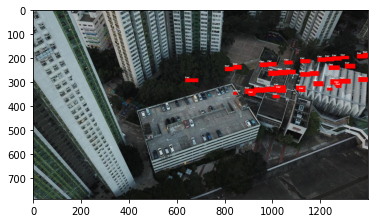

In [ ]:
random.seed(0)
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)),(255, 0, 0))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]


print(annotation_file)

#Get the corresponding image file
image_file = annotation_file.replace("txtannotations", "images").replace("txt", "jpg")

print(image_file)

assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
cat /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-test-dev/VisDrone-test-dev/txtannotations/9999941_00000_d_0000021.txt

1 1.742 0.159 0.010 0.005
4 0.586 0.312 0.025 0.021
4 0.610 0.303 0.025 0.023
4 0.690 0.290 0.027 0.023
4 0.714 0.287 0.027 0.022
4 0.763 0.278 0.024 0.019
4 0.813 0.271 0.030 0.021
4 0.862 0.263 0.025 0.021
4 0.886 0.260 0.027 0.021
4 0.907 0.256 0.028 0.021
4 0.931 0.251 0.024 0.017
4 0.982 0.245 0.029 0.021
4 1.000 0.240 0.030 0.024
4 1.024 0.236 0.028 0.024
4 1.164 0.334 0.034 0.022
4 1.141 0.339 0.033 0.021
4 0.987 0.368 0.030 0.024
4 0.932 0.377 0.032 0.025
4 0.905 0.381 0.034 0.026
4 0.852 0.390 0.029 0.025
4 0.840 0.336 0.028 0.024
4 0.813 0.341 0.029 0.023
4 0.737 0.414 0.034 0.029
4 0.709 0.420 0.029 0.026
4 0.677 0.424 0.034 0.027
4 0.649 0.430 0.032 0.027
4 0.718 0.335 0.029 0.026
4 0.746 0.331 0.028 0.026
4 0.770 0.328 0.028 0.024
4 0.899 0.305 0.032 0.022
4 0.947 0.297 0.030 0.025
10 0.603 0.441 0.010 0.014
4 0.474 0.372 0.039 0.019
1 1.557 0.391 0.008 0.006
1 1.563 0.393 0.009 0.006
1 1.626 0.377 0.010 0.005
1 1.635 0.381 0.009 0.006
1 1.388 0.423 0.009 0.006
4 0.741 0.4

# Preprocessing for RetinaNet

## Creating XML files from txt annotations
The following script was run locally to convert annotations from a custom format to the standard PASCAL format

In [ ]:
# import cv2
# import os
# import numpy as np


# input_img_folder = 'VisDrone2019-DET-train/images'
# input_ann_folder = 'VisDrone2019-DET-train/annotations'
# output_ann_folder = 'VisDrone2019-DET-train/annotations_new'
# output_img_folder = 'VisDrone2019-DET-train/images_new'

# os.makedirs(output_img_folder, exist_ok=True)
# os.makedirs(output_ann_folder, exist_ok=True)


# image_list = os.listdir(input_img_folder)
# annotation_list = os.listdir(input_ann_folder)

# label_dict = {
# 	"0" : "Ignore",
# 	"1" : "Pedestrian",
# 	"2" : "People",
# 	"3" : "Bicycle",
# 	"4" : "Car",
# 	"5" : "Van",
# 	"6" : "Truck",
# 	"7" : "Tricycle",
# 	"8" : "Awning-tricycle",
# 	"9" : "Bus",
# 	"10" : "Motor",
# 	"11" : "Others"
# }

# thickness = 2
# color = (255,0,0)
# count = 0

# def object_string(label, bbox):
# 	req_str = '''
# 	<object>
# 		<name>{}</name>
# 		<pose>Unspecified</pose>
# 		<truncated>0</truncated>
# 		<difficult>0</difficult>
# 		<bndbox>
# 			<xmin>{}</xmin>
# 			<ymin>{}</ymin>
# 			<xmax>{}</xmax>
# 			<ymax>{}</ymax>
# 		</bndbox>
# 	</object>
# 	'''.format(label, bbox[0], bbox[1], bbox[2], bbox[3])
# 	return req_str

# for annotation in annotation_list:
# 	annotation_path = os.path.join(os.getcwd(), input_ann_folder, annotation)
# 	xml_annotation = annotation.split('.txt')[0] + '.xml'
# 	xml_path = os.path.join(os.getcwd(), output_ann_folder, xml_annotation)
# 	img_file = annotation.split('.txt')[0] + '.jpg'
# 	img_path = os.path.join(os.getcwd(), input_img_folder, img_file)
# 	output_img_path = os.path.join(os.getcwd(), output_img_folder, img_file)
# 	img = cv2.imread(img_path)
# 	annotation_string_init = '''
# <annotation>
# 	<folder>annotations</folder>
# 	<filename>{}</filename>
# 	<path>{}</path>
# 	<source>
# 		<database>Unknown</database>
# 	</source>
# 	<size>
# 		<width>{}</width>
# 		<height>{}</height>
# 		<depth>{}</depth>
# 	</size>
# 	<segmented>0</segmented>'''.format(img_file, img_path, img.shape[0], img.shape[1], img.shape[2])

# 	file = open(annotation_path, 'r')
# 	lines = file.readlines()
# 	for line in lines:
# 		new_line = line.strip('\n').split(',')
# 		new_coords_min = (int(new_line[0]), int(new_line[1]))
# 		new_coords_max = (int(new_line[0])+int(new_line[2]), int(new_line[1])+int(new_line[3]))
# 		bbox = (int(new_line[0]), int(new_line[1]), int(new_line[0])+int(new_line[2]), int(new_line[1])+int(new_line[3]))
# 		label = label_dict.get(new_line[5])
# 		req_str = object_string(label, bbox)
# 		annotation_string_init = annotation_string_init + req_str
# 		#cv2.rectangle(img, new_coords_min, new_coords_max, color, thickness)
# 	cv2.imwrite(output_img_path, img)
# 	annotation_string_final = annotation_string_init + '</annotation>'
# 	f = open(xml_path, 'w')
# 	f.write(annotation_string_final)
# 	f.close()
# 	count += 1
# 	print('[INFO] Completed {} image(s) and annotation(s) pair'.format(count))

## Checking the .xml files

In [ ]:
!cat /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-val/annotations/0000001_02999_d_0000005.xml


<annotation>
	<folder>annotations</folder>
	<filename>0000001_02999_d_0000005.jpg</filename>
	<path>C:\Users\lbsre\Desktop\Project\YOLOv5-Multibackbone-Compression\Object Detection\VisDrone2019-DET-val\VisDrone2019-DET-val/images\0000001_02999_d_0000005.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1080</width>
		<height>1920</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>Car</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>871</xmin>
			<ymin>572</ymin>
			<xmax>925</xmax>
			<ymax>664</ymax>
		</bndbox>
	</object>
	
	<object>
		<name>Car</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>948</xmin>
			<ymin>592</ymin>
			<xmax>1010</xmax>
			<ymax>684</ymax>
		</bndbox>
	</object>
	
	<object>
		<name>Car</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>


## Define all classes as a dictionary:

In [ ]:
voc_classes = {
    "Ignore":0,
    "Pedestrian":1,
    "People":2,
    "Bicycle":3,
    "Car":4,
    "Van":5,
    "Truck":6,
    "Tricycle":7,
    "Awning-tricycle":8,
    "Bus":9,
    "Motor":10,
    "Others":11
}

## Required File Structure

In [ ]:
# └── dataset
#     ├── Annotations
#     │   ├── 1.xml
#     │   ├── 2.xml
#     │   └── ....
#     ├── ImageSets
#     │   └── Main
#     │  	    ├── train.txt
#     │       └── test.txt
#     └── JPEGImages
#         ├── 1.jpg
#         ├── 2.jpg
#         └── ...

## Creating train.txt for training

In [ ]:
from os import listdir
from os.path import isfile, join

dataset_directory = "/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images"

files = [join(dataset_directory,file) for file in listdir(dataset_directory) if isfile(join(dataset_directory,file))]

with open("/content/drive/MyDrive/VisDrone2019-DET/train.txt", "w") as train:
  for file in files:
    name = file.split("\\")[-1]
    name = name.split(".")[0]
    train.write(name + "\n")
    print("train:    " + name)
train.close()

Streaming output truncated to the last 5000 lines.
train:    /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images/9999982_00000_d_0000142
train:    /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images/9999982_00000_d_0000141
train:    /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images/9999982_00000_d_0000154
train:    /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images/9999982_00000_d_0000140
train:    /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images/9999982_00000_d_0000153
train:    /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images/9999982_00000_d_0000149
train:    /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images/9999982_00000_d_0000150
train:    /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images/9999982_00000_d_0000148
train:    /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images/9999982_00000_d_0000147
train:    /co

## Training Preprocessing

In [ ]:
classes=pd.DataFrame([{'class':'Ignore','label':0},
                     {'class':'Pedestrian', 'label':1},
                     {'class':'People', 'label':2},
                     {'class':'Bicycle', 'label':3},
                     {'class':'Car', 'label':4},
                     {'class':'Van', 'label':5},
                     {'class':'Truck', 'label':6},
                     {'class':'Tricycle', 'label':7},
                     {'class':'Awning-tricycle', 'label':8},
                     {'class':'Bus', 'label':9},
                     {'class':'Motor', 'label':10},
                     {'class':'Others', 'label':11}]
                    )
classes.to_csv("/content/drive/MyDrive/RetinaNet/classes.csv",index=False,header=False)

In [ ]:
train_labels = pd.read_csv('/content/drive/MyDrive/VisDrone2019-DET/train_labels.csv')
train_labels

,filename,width,height,class,xmin,ymin,xmax,ymax
0,9999991_00000_d_0000007.jpg,1050,1400,Car,884,952,968,1042
1,9999991_00000_d_0000007.jpg,1050,1400,Car,175,945,243,1050
2,9999991_00000_d_0000007.jpg,1050,1400,Car,254,889,311,997
3,9999991_00000_d_0000007.jpg,1050,1400,Tricycle,193,852,267,917
4,9999991_00000_d_0000007.jpg,1050,1400,Van,175,803,255,892
...,...,...,...,...,...,...,...,...
353545,0000199_00303_d_0000163.jpg,540,960,Car,426,83,435,90
353546,0000199_00303_d_0000163.jpg,540,960,Car,430,86,439,93
353547,0000199_00303_d_0000163.jpg,540,960,Car,434,88,444,96
353548,0000199_00303_d_0000163.jpg,540,960,Ignore,459,57,465,64


In [ ]:
val_labels = pd.read_csv('/content/drive/MyDrive/VisDrone2019-DET/val_labels.csv')
val_labels

,filename,width,height,class,xmin,ymin,xmax,ymax
0,0000001_03999_d_0000007.jpg,1080,1920,Car,974,945,1061,1080
1,0000001_03999_d_0000007.jpg,1080,1920,Car,946,763,1018,883
2,0000001_03999_d_0000007.jpg,1080,1920,Pedestrian,777,824,803,874
3,0000001_03999_d_0000007.jpg,1080,1920,Pedestrian,1012,849,1040,901
4,0000001_03999_d_0000007.jpg,1080,1920,Pedestrian,992,693,1017,737
...,...,...,...,...,...,...,...,...
40164,0000364_01569_d_0000781.jpg,540,960,Motor,521,267,548,289
40165,0000364_01569_d_0000781.jpg,540,960,People,525,259,540,283
40166,0000364_01569_d_0000781.jpg,540,960,Motor,505,183,515,195
40167,0000364_01569_d_0000781.jpg,540,960,Motor,358,201,375,212


In [ ]:
annotation = train_labels[['filename','xmin','ymin','xmax', 'ymax','class']]
annotation

In [ ]:
annotation_val = val_labels[['filename','xmin','ymin','xmax', 'ymax','class']]
annotation_val

,filename,xmin,ymin,xmax,ymax,class
0,0000001_03999_d_0000007.jpg,974,945,1061,1080,Car
1,0000001_03999_d_0000007.jpg,946,763,1018,883,Car
2,0000001_03999_d_0000007.jpg,777,824,803,874,Pedestrian
3,0000001_03999_d_0000007.jpg,1012,849,1040,901,Pedestrian
4,0000001_03999_d_0000007.jpg,992,693,1017,737,Pedestrian
...,...,...,...,...,...,...
40164,0000364_01569_d_0000781.jpg,521,267,548,289,Motor
40165,0000364_01569_d_0000781.jpg,525,259,540,283,People
40166,0000364_01569_d_0000781.jpg,505,183,515,195,Motor
40167,0000364_01569_d_0000781.jpg,358,201,375,212,Motor


In [ ]:
annotation['filename'] = '/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-train/images/' + annotation['filename']
annotation.iloc[0]['filename']

In [ ]:
annotation_val['filename'] = '/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-val/images/' + annotation_val['filename']
annotation_val.iloc[0]['filename']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


'/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-val/images/0000001_03999_d_0000007.jpg'

In [ ]:
invalid_indices = np.array(annotation.loc[annotation.ymin == annotation.ymax].index)
invalid_indices

In [ ]:
invalid_indices2 = np.array(annotation_val.loc[annotation_val.ymin == annotation_val.ymax].index)
invalid_indices2

array([], dtype=int64)

In [ ]:
annotation.drop(invalid_indices, inplace=True)

In [ ]:
annotation.to_csv("/content/drive/MyDrive/RetinaNet/annotation.csv",index=False,header=False)
annotation

In [ ]:
annotation_val.to_csv("/content/drive/MyDrive/RetinaNet/annotation_val.csv",index=False,header=False)
annotation_val

,filename,xmin,ymin,xmax,ymax,class
0,/content/drive/MyDrive/VisDrone2019-DET/VisDro...,974,945,1061,1080,Car
1,/content/drive/MyDrive/VisDrone2019-DET/VisDro...,946,763,1018,883,Car
2,/content/drive/MyDrive/VisDrone2019-DET/VisDro...,777,824,803,874,Pedestrian
3,/content/drive/MyDrive/VisDrone2019-DET/VisDro...,1012,849,1040,901,Pedestrian
4,/content/drive/MyDrive/VisDrone2019-DET/VisDro...,992,693,1017,737,Pedestrian
...,...,...,...,...,...,...
40164,/content/drive/MyDrive/VisDrone2019-DET/VisDro...,521,267,548,289,Motor
40165,/content/drive/MyDrive/VisDrone2019-DET/VisDro...,525,259,540,283,People
40166,/content/drive/MyDrive/VisDrone2019-DET/VisDro...,505,183,515,195,Motor
40167,/content/drive/MyDrive/VisDrone2019-DET/VisDro...,358,201,375,212,Motor


# Preprocessing for SSD MobileNet

## Cloning Tensorflow Model Zoo repo

In [ ]:
!git clone https://github.com/tensorflow/models.git

## Install required Packages

In [ ]:
!pip install pillow Cython lxml jupyter matplotlib protobuf

## Install Tensorflow Object Detection API

In [ ]:
!pip install tensorflow-object-detection-api

## Run this script locally to generate tf.records file.

In [ ]:
# from __future__ import division
# from __future__ import print_function
# from __future__ import absolute_import
# from collections import namedtuple, OrderedDict
# from object_detection.utils import dataset_util

# import os
# import io
# import pandas as pd
# import tensorflow as tf

# from PIL import Image
# import sys
# sys.path.append('../')

# ####Delete all flags before declare#####

# def del_all_flags(FLAGS):
#     flags_dict = FLAGS._flags()
#     keys_list = [keys for keys in flags_dict]
#     for keys in keys_list:
#         FLAGS.__delattr__(keys)

# del_all_flags(tf.compat.v1.flags.FLAGS)

# flags = tf.compat.v1.flags
# flags.DEFINE_string('csv_input', '', '/content/drive/MyDrive/VisDrone2019-DET-test-dev/VisDrone-test-dev/annotations_new.csv')
# flags.DEFINE_string('output_path', '', '/content/drive/MyDrive/VisDrone2019-DET-test-dev/VisDrone-test-dev/train.record')
# flags.DEFINE_string('image_dir', '', '/content/drive/MyDrive/VisDrone2019-DET-test-dev/VisDrone-test-dev/images')
# FLAGS = flags.FLAGS


# # TO-DO replace this with label map
# def class_text_to_int(row_label):
#     if row_label == 'Ignore':
#         return 1
#     if row_label == 'Pedestrian':
#         return 2
#     if row_label == 'People':
#         return 3
#     if row_label == 'Bicycle':
#         return 4
#     if row_label == 'Car':
#         return 5
#     if row_label == 'Van':
#         return 6
#     if row_label == 'Truck':
#         return 7
#     if row_label == 'tricycle':
#         return 8
#     if row_label == 'Awning-tricycle':
#         return 9
#     if row_label == 'Bus':
#         return 10
#     if row_label == 'Motor':
#         return 11
#     if row_label == 'Others':
#         return 12
#     else:
#         return 0


# def split(df, group):
#     data = namedtuple('data', ['filename', 'object'])
#     gb = df.groupby(group)
#     return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


# def create_tf_example(group, path):
#     with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
#         encoded_jpg = fid.read()
#     encoded_jpg_io = io.BytesIO(encoded_jpg)
#     image = Image.open(encoded_jpg_io)
#     width, height = image.size

#     filename = group.filename.encode('utf8')
#     image_format = b'jpg'
#     xmins = []
#     xmaxs = []
#     ymins = []
#     ymaxs = []
#     classes_text = []
#     classes = []

#     for index, row in group.object.iterrows():
#         xmins.append(row['xmin'] / width)
#         xmaxs.append(row['xmax'] / width)
#         ymins.append(row['ymin'] / height)
#         ymaxs.append(row['ymax'] / height)
#         classes_text.append(row['class'].encode('utf8'))
#         classes.append(class_text_to_int(row['class']))

#     tf_example = tf.train.Example(features=tf.train.Features(feature={
#         'image/height': dataset_util.int64_feature(height),
#         'image/width': dataset_util.int64_feature(width),
#         'image/filename': dataset_util.bytes_feature(filename),
#         'image/source_id': dataset_util.bytes_feature(filename),
#         'image/encoded': dataset_util.bytes_feature(encoded_jpg),
#         'image/format': dataset_util.bytes_feature(image_format),
#         'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
#         'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
#         'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
#         'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
#         'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
#         'image/object/class/label': dataset_util.int64_list_feature(classes),
#     }))
#     return tf_example


# def main(_):
#     writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
#     path = os.path.join(FLAGS.image_dir)
#     examples = pd.read_csv(FLAGS.csv_input)
#     grouped = split(examples, 'filename')
#     for group in grouped:
#         tf_example = create_tf_example(group, path)
#         writer.write(tf_example.SerializeToString())

#     writer.close()
#     output_path = os.path.join(os.getcwd(), FLAGS.output_path)
#     print('Successfully created the TFRecords: {}'.format(output_path))


# if __name__ == '__main__':
#         tf.app.run()

Path to tf.record file: /content/drive/MyDrive/test.record